In [65]:
import numpy as np
import healpy as hp
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import astropy.table
import astropy.coordinates
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.utils.data import conf
from astropy.coordinates.tests.utils import randomly_sample_sphere
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
sns.set_style('whitegrid')
sns.set_context('talk')

In [238]:
cat = astropy.table.Table.read("data/asas_snii_ps1_x_vcsos_outjoins.csv",format='csv')
#cat=cat[cat['Distance_ap']>0]

In [244]:
#Set ra,dec,dist to exist for every obj in the catalogue - Gaia ra,dec override ASAS+PS1 ra,dec
cat['ra']=cat['RA_ap'].copy()
cat['dec']=cat['DEC_ap'].copy()
cat['D']=cat['Distance_ap'].copy()
cat['Type']=cat['Type_ap'].copy()


mg = (cat['ra_g']>0)
print(mg.sum(),(~mg).sum(),(cat['ra_g']>0).sum(),cat['ra_g'].size)

cat['ra'][mg]=cat['ra_g'][mg]
cat['dec'][mg]=cat['dec_g'][mg]
cat['D'][mg]=cat['D_g'][mg]
cat['Type'][mg]=cat['Type_g'][mg]

m_common = (cat['REF_ap']>0) & (cat['source_id_g']>0)
print(m_common.sum(),cat[m_common]['ra'].size)
m_ab = cat['Type']=='RRAB'
m_c = cat['Type']=='RRC'
print(m_ab.sum(),m_c.sum())
mm=(cat['RA_ap']>0)

print(mm.sum(),(cat['Distance_ap']>0).sum())

174926 0 174926 192260
63836 63836
8789 8471
81170 81170


In [240]:
mD = cat['D']>0
cat['D'][mD].size,mD.sum(),(~mD).size
#cat[~mD]

(192260, 192260, 192260)

In [241]:
f'{lo},{bo} a'

'3.9905979185918623 rad,0.13699523537125383 rad a'

In [269]:
def completeness_los(lon, lat, cat0, unit=u.deg, frame='galactic',sky_tol=1*u.deg, Nmin=200, verbose=False):
    
    #Create skycoords object for cat
    cat = cat0[cat0['Distance_ap']>0.]
    sc = SkyCoord(ra=cat['RA_ap']*u.deg,dec=cat['DEC_ap']*u.deg, 
                  distance=cat['Distance_ap'], frame='icrs')
    
    #If los has DEC<-30, PS1 is not available. substitute chosen l.o.s. by 
    #symmetric field in w.r.t. ecliptic plane
    lo, bo = lon, lat
    sco = SkyCoord(lo, bo, unit=unit, frame=frame)
    
    if sco.icrs.dec<=-30*u.deg:
      #Get ecliptic coords  
      elon,elat = sco.barycentrictrueecliptic.lon, sco.barycentrictrueecliptic.lat   
      #Reflect w.r.t to ecliptic plane  
      eco_new = SkyCoord(elon, -elat, frame='barycentrictrueecliptic')
      #and rotate in ra (this is to preserve symmetric w.r.t Galactic plane)
      ra_new, dec_new = 180.*u.deg-eco_new.icrs.ra, eco_new.icrs.dec
      #convert back to galactic
      new = SkyCoord(ra_new, dec_new, unit=unit, frame='icrs')  
      lo, bo = new.galactic.l, new.galactic.b  
      if verbose: 
        print("Field outside PS1 footprint -> getting estimate from symmetric field w.r.t ecliptic plane") 
        print(f'{lon},{lat} -> {lo},{bo}')
    
    #SkyCoord object for center of field   
    sco = SkyCoord(lo, bo, unit=unit, frame=frame)
    sep = sc.separation(sco)
        
    #Manage only stars in selected line of sight
    mlos = sep<=sky_tol
    clos = cat[mlos]  #full cat
    sclos = sc[mlos]  #skycoo obj
        
    #Total stars in selected line of sight
    Ntot = sclos.size 
    
    #In line of sight, select stars in common between ap and g surveys
    m_common = (clos['RA_ap']>0.) & (clos['ra_g']>0.)
    Ncommon = clos[m_common]['RA_ap'].size #change to m_common.sum()
         
    #mean Completeness (integrated in r)
    Cmean = Ncommon/Ntot
        
    #Sort by increasing r
    mr = np.argsort(clos['Distance_ap'])
    clos_D_sort = clos['Distance_ap'][mr]
    #Select bin edges every Nmin stars in total
    r_bin_edges =  clos_D_sort[::Nmin]
    
    #If fewer than 1/2Nmin stars in last bin, move edge to merge with previous bin into a single one
    if ~(clos_D_sort.size % Nmin > np.int(0.5*Nmin)): r_bin_edges[-1]=np.max(clos['Distance_ap'])     
    else: r_bin_edges = np.append(r_bin_edges,clos['Distance_ap'].max())  
    
    #Count stars in (irregularly spaced) r bins  
    try:
      Ntot_r = np.histogram(clos['Distance_ap'], bins=r_bin_edges)[0]
      Ncommon_r = np.histogram(clos['Distance_ap'][m_common], bins=r_bin_edges)[0]
    except:
      if verbose: print(r_bin_edges)  

    #Compute completeness
    C= Ncommon_r/Ntot_r
    mz = (Ncommon_r>0)
    eC = np.zeros_like(Ntot_r) #init to deal separately with Ncommon_r==0 avoiding warning
#     eC[mz] = C[mz]*np.sqrt((np.sqrt(Ncommon_r[mz])/Ncommon_r[mz])**2 
#                        + (np.sqrt(Ntot_r[mz])/Ntot_r[mz])**2)
#     eC[~mz] = C[~mz]*(np.sqrt(Ntot_r[~mz])/Ntot_r[~mz]) #first term is 0 when Ncommon_r==0
    eC = C*(np.sqrt(Ntot_r)/Ntot_r) #first term is 0 when Ncommon_r==0
    eC[mz] = C[mz]*np.sqrt((np.sqrt(Ncommon_r[mz])/Ncommon_r[mz])**2 
                       + (np.sqrt(Ntot_r[mz])/Ntot_r[mz])**2)

   
    return (np.array(r_bin_edges), C, eC, Ntot_r, Ncommon_r, Cmean)

In [9]:
sc = SkyCoord(ra=cat['ra']*u.deg,dec=cat['dec']*u.deg)
lo,bo=180.,90.
sco = SkyCoord(lo*u.deg, bo*u.deg, frame='galactic')

In [10]:
sc.separation(sco)

<Angle [ 89.43105175,  66.72341344, 118.3484768 , ..., 125.5762971 ,
        126.19380353, 126.08950183] deg>

In [270]:
rs, C, eC, Nt_r, Nc_r, cc = completeness_los(90.*u.deg, 50.*u.deg, cat, sky_tol=20*u.deg)
print(rs, C, eC)

[  1.03987      4.81989      5.57657      6.50782     12.64736325
  23.01441979  33.11309935  64.56542063 103.75287074] [0.85       0.865      0.885      0.905      0.92       0.93
 0.88944724 0.8466899 ] [0.08867074 0.08981161 0.09132976 0.09284463 0.09397872 0.09473384
 0.09189692 0.07381051]


In [211]:
#np.min(rs)
print(rs)
rall.min(),rall.max(),rall.size

[  1.03987      5.90925      9.31537547  12.50097768  16.01688767
  20.47338742  26.03696265  39.90194273  63.1052371   75.02613159
  84.98402958 108.29167775]


(1.0398699999999999, 108.29167775, 2070)

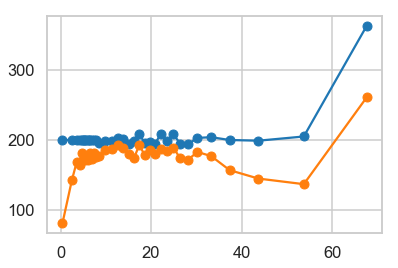

In [272]:
rs, C, eC, Nt_r, Nc_r, _ = completeness_los(90.*u.deg, 30.*u.deg, cat, sky_tol=40*u.deg)
plt.plot(rs[:-1],Nt_r,'o-')
plt.plot(rs[:-1],Nc_r,'o-')

Text(0, 0.5, 'Completeness (%)')

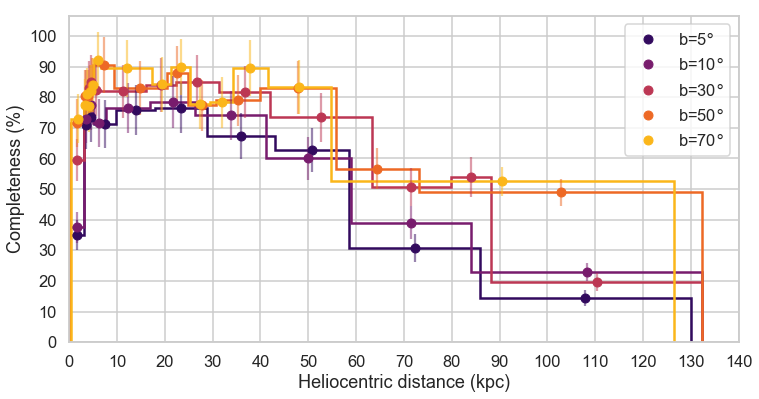

In [306]:
fig=plt.figure(1,figsize=(12,6))
ax=fig.add_subplot(111)

bs=[5,10,20,30,50,70]
bs=[5,10,30,50,70]
cols=sns.color_palette("inferno", len(bs))
for jj in range(len(bs)) : #np.arange(0,360.,90.):
 
 bo=bs[jj]
 rs, C, eC, Nt_r, Nc_r, _ = completeness_los(180.*u.deg, bo*u.deg, cat, 
                                             sky_tol=30*u.deg, Nmin=200)
 ro = (rs[:-1] + rs[1:])/2.   
 ax.plot(ro,C*100,'o',label=f"b={bo}$\degree$",color=cols[jj])
 ax.hist(ro,weights=C*100,bins=rs,histtype='step',lw=2.5,color=cols[jj])
 ax.errorbar(ro,C*100,yerr=eC*100,marker=None,alpha=0.5,color=cols[jj],ls='none')


ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.yaxis.set_major_locator(plt.MultipleLocator(10))
plt.legend()
ax.set_xlim(0,100)
#plt.grid()
ax.set_xlim(0,140)
ax.set_xlabel('Heliocentric distance (kpc)')
ax.set_ylabel('Completeness (%)')

In [246]:
5*np.log10(50*1e3)-5. , 10**((13.+5.)/5.)/1000., 10**((15.+5.)/5.)/1000.

(18.494850021680094, 3.981071705534973, 10.0)

Field outside PS1 footprint -> getting estimate from symmetric field w.r.t ecliptic plane
10.0 deg,-30.0 deg -> 2.7434238424277355 deg,30.040213418026724 deg
Field outside PS1 footprint -> getting estimate from symmetric field w.r.t ecliptic plane
12.0 deg,-30.0 deg -> 0.7426136508279756 deg,30.040100310397516 deg
Field outside PS1 footprint -> getting estimate from symmetric field w.r.t ecliptic plane
12.25 deg,-30.0 deg -> 0.49251255224149515 deg,30.04008273189081 deg


Text(0, 0.5, 'Completeness (%)')

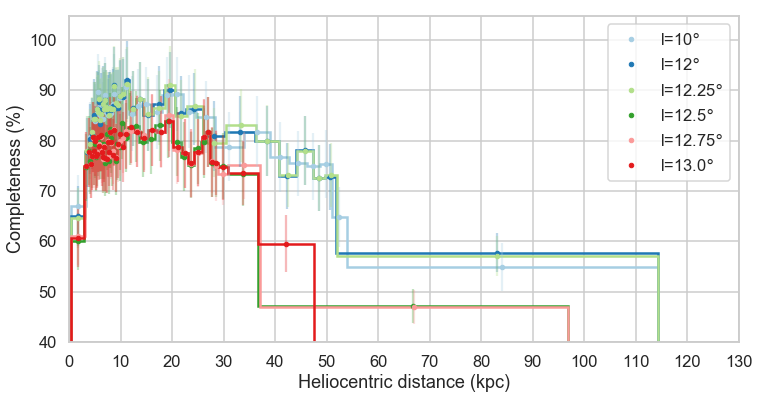

In [319]:

fig=plt.figure(1,figsize=(12,6))
ax=fig.add_subplot(111)

ls=[0,20,90,240,300]
#ls=[10,11,12,12.5,13,16,20]
ls=[10,12,12.25,12.5,12.75,13.]
cols=sns.cubehelix_palette(8, start=.5, rot=-.75)
cols=sns.color_palette("Paired", len(ls))
for jj in range(len(ls)) : #np.arange(0,360.,90.):
 
 lo=ls[jj]
 rs, C, eC, Nt_r, Nc_r, _ = completeness_los(lo*u.deg, -30*u.deg, cat, sky_tol=25*u.deg,Nmin=300,verbose=True)
#  ax.errorbar(rs[:-1],C,yerr=eC,alpha=0.5,color=cols[jj])
#  ax.plot(rs[:-1],C,'-',alpha=0.99,label=f'l={lo}$\degree$',color=cols[jj])
 ro = (rs[:-1] + rs[1:])/2.   
 ax.plot(ro,C*100,'.',label=f'l={lo}$\degree$',color=cols[jj])
 ax.hist(ro,weights=C*100,bins=rs,histtype='step',lw=2.5,color=cols[jj])
 ax.errorbar(ro,C*100,yerr=eC*100,marker=None,alpha=0.3,color=cols[jj],ls='none')


# for jj in range(len(ls)) : #np.arange(0,360.,90.):
 
#  lo=ls[jj]
#  rs, C, eC, Nt_r, Nc_r = completeness_los(lo*u.deg, 50*u.deg, cat, sky_tol=30*u.deg,Nmin=250)
#  ax.errorbar(rs[:-1],C,yerr=eC,alpha=0.1,color=cols[jj])
#  ax.plot(rs[:-1],C,'-',alpha=0.5,label=f'l={lo}$\degree$',color=cols[jj])
#  #print(bo,np.median(C),np.mean(eC));   

    
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.yaxis.set_major_locator(plt.MultipleLocator(10))

plt.legend()
ax.set_xlim(0,130)
ax.set_ylim(40)
ax.set_xlabel('Heliocentric distance (kpc)')
ax.set_ylabel('Completeness (%)')
#plt.grid()

6


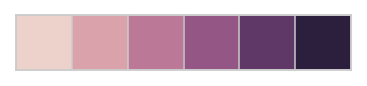

In [322]:
pal=sns.cubehelix_palette(len(ls))
sns.palplot(pal)
print(len(pal))

In [18]:
lo,bo = 300, -20
gco=SkyCoord(lo*u.deg, bo*u.deg, frame='galactic')
#gcecl=gco.transform_to('ecliptic')
gco.barycentrictrueecliptic.lon,gco.barycentrictrueecliptic.lat

(<Longitude 250.79752166 deg>, <Latitude -66.50428032 deg>)

In [254]:
ls, bs, _ = randomly_sample_sphere(3000)
Cs = np.array([])
Cms = np.array([]) 
for jj in range(ls.size):
  a,b,c, Nt_r, Nc_r, Cm = completeness_los(np.degrees(ls[jj]), np.degrees(bs[jj]), cat, 
                                           sky_tol=10*u.deg,Nmin=300,
                                           unit=u.deg, frame='galactic',
                                           verbose=False)
  if Nt_r.sum()>0: C = Nc_r.sum()/Nt_r.sum()
  else: C = 0.      
  Cs = np.append(Cs,C)  
  Cms = np.append(Cms,Cm)  

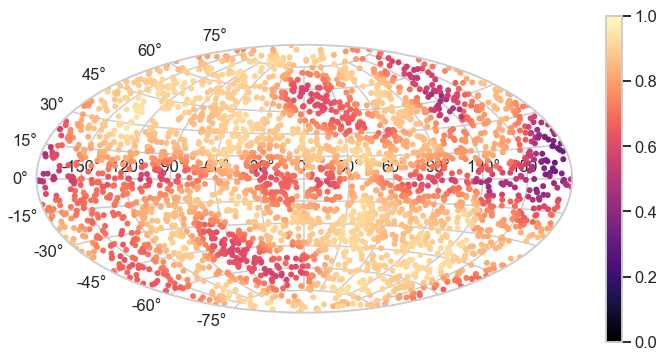

In [255]:
sc=SkyCoord(l=ls, b=bs,frame='galactic')
cm=plt.cm.magma
cm.set_under('gray')
plt.figure(1,figsize=(12,6))
plt.subplot(111, projection='aitoff')
im=plt.scatter(-sc.l.wrap_at(np.pi*u.rad).radian,sc.b.radian,s=20,c=Cms,cmap=cm,vmin=0,vmax=1)
plt.colorbar(im)
#plt.ylim(-90,90)

Text(0.5, 1.0, 'equatorial')

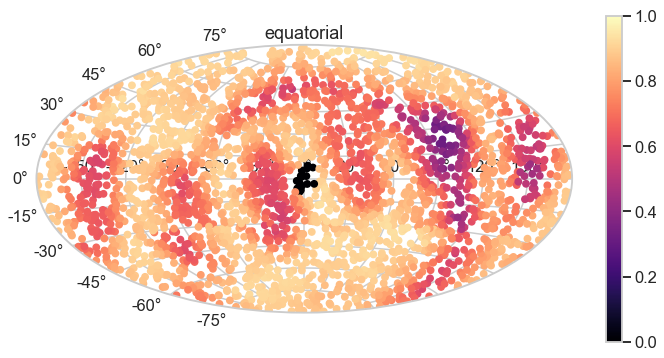

In [195]:
sc=SkyCoord(l=ls, b=bs,frame='galactic')
cm=plt.cm.magma
cm.set_under('gray')
plt.figure(1,figsize=(12,6))
plt.subplot(111, projection='aitoff')
im=plt.scatter(sc.icrs.ra.wrap_at(np.pi*u.rad).radian,
               sc.icrs.dec.radian,s=40,c=Cms,cmap=cm,vmin=0,vmax=1)
plt.colorbar(im)
plt.title('equatorial')
#plt.ylim(-90,90)

Text(0.5, 1.0, 'ecliptic')

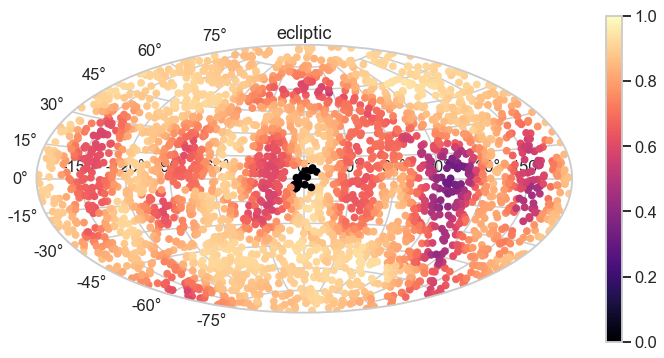

In [196]:
sc=SkyCoord(l=ls, b=bs,frame='galactic')
cm=plt.cm.magma
cm.set_under('gray')
plt.figure(1,figsize=(12,6))
plt.subplot(111, projection='aitoff')
im=plt.scatter(sc.barycentrictrueecliptic.lon.wrap_at(np.pi*u.rad).radian,
               sc.barycentrictrueecliptic.lat.radian,s=40,c=Cms,cmap=cm,vmin=0,vmax=1)
plt.colorbar(im)
plt.title('ecliptic')